<a href="https://colab.research.google.com/github/EEarth1270/houseprice-prediction/blob/randomforest/HousePriceRandomForesr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from scipy.stats import iqr
from pandas.api.types import CategoricalDtype 


In [156]:
train_dataset = pd.read_csv('/content/drive/My Drive/Datasci/train.csv')

# Pre-processing

In [110]:
corrMatrix = train_dataset.corr()
print(corrMatrix['SalePrice'].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

In [ ]:
print(train_dataset.info())

In [ ]:
# a=pd.isna(train_dataset).sum() > 0
# text_file = open("/content/drive/My Drive/Datasci/out4.txt", "w")
# n = text_file.write(a.to_string())
# text_file.close()

In [5]:
# train_dataset['LotFrontage'].fillna(0,inplace=True)

In [161]:
col = ['Id','OverallQual','TotalBsmtSF','GrLivArea','GarageCars','GarageArea','1stFlrSF']
# col = ['Id','MSSubClass','LotArea','LotFrontage','OverallQual','TotalBsmtSF','GrLivArea','GarageCars','GarageArea']
salePrice = train_dataset['SalePrice']

In [162]:
train_dataset= train_dataset[col]

Cleaning Data

Remove Outlier with IQR


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


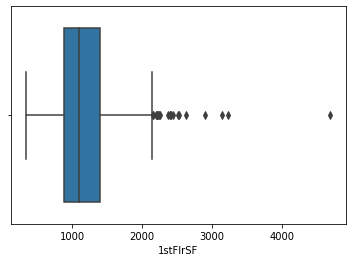

In [166]:
sns.boxplot(train_dataset['1stFlrSF'])

In [164]:

iqr_1stFlrSF = iqr(train_dataset['1stFlrSF']) *1.5
Q75 = train_dataset['1stFlrSF'].quantile(0.75) +iqr_1stFlrSF
Q25 = train_dataset['1stFlrSF'].quantile(0.25) -iqr_1stFlrSF
print(iqr_1stFlrSF)
print(Q25,Q75)

763.875
118.125 2155.125


In [167]:
train_dataset = train_dataset[train_dataset['1stFlrSF']<2919]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


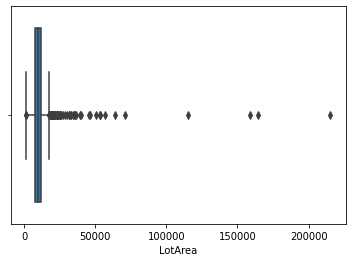

In [67]:
sns.boxplot(train_dataset['LotArea'])

In [ ]:
iqr_lotArea = iqr(train_dataset['LotArea']) *1.5
Q75 = train_dataset['LotArea'].quantile(0.75) +iqr_lotArea
Q25 = train_dataset['LotArea'].quantile(0.25) -iqr_lotArea
print(iqr_lotArea)
print(Q25,Q75)

6072.0
1481.5 17673.5


In [68]:
# train_dataset = train_dataset[train_dataset['LotArea']>1481.5]
train_dataset = train_dataset[train_dataset['LotArea']<17673.5]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


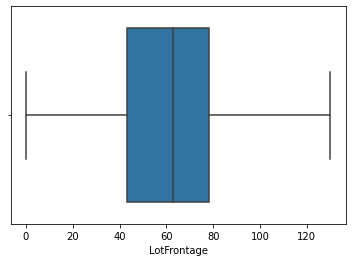

In [13]:
sns.boxplot(train_dataset['LotFrontage'])

In [ ]:
iqr_lotFrontage = iqr(train_dataset['LotFrontage']) *1.5
Q75 = train_dataset['LotFrontage'].quantile(0.75)
Q25 = train_dataset['LotFrontage'].quantile(0.25)
print(iqr_lotFrontage)
print(Q25,Q75)

52.5
43.0 78.0


In [12]:
train_dataset = train_dataset[train_dataset['LotFrontage']<130.5]
# train_dataset = train_dataset[train_dataset['LotFrontage']>9]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


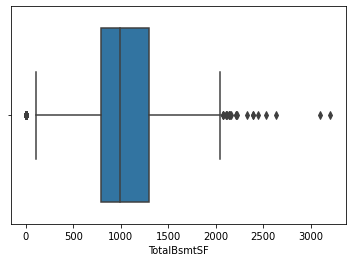

In [168]:
sns.boxplot(train_dataset['TotalBsmtSF'])

In [ ]:
iqr_TotalBsmtSF = iqr(train_dataset['TotalBsmtSF']) *1.5
Q75 = train_dataset['TotalBsmtSF'].quantile(0.75)
Q25 = train_dataset['TotalBsmtSF'].quantile(0.25)
print(iqr_TotalBsmtSF)
print(Q25,Q75)

710.625
793.0 1266.75


In [169]:
train_dataset = train_dataset[train_dataset['TotalBsmtSF']<1980.5]
# train_dataset = train_dataset[train_dataset['TotalBsmtSF']>80.5]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


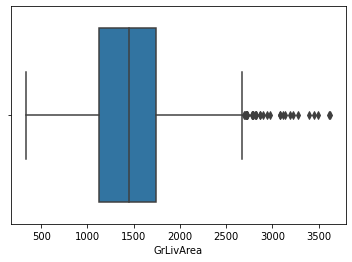

In [170]:
sns.boxplot(train_dataset['GrLivArea'])

In [ ]:
iqr_GrLivArea = iqr(train_dataset['GrLivArea']) *1.5
Q75 = train_dataset['GrLivArea'].quantile(0.75)
Q25 = train_dataset['GrLivArea'].quantile(0.25)
print(iqr_GrLivArea)
print(Q25,Q75)

915.375
1117.75 1728.0


In [117]:
train_dataset = train_dataset[train_dataset['GrLivArea']<2615]
# train_dataset = train_dataset[train_dataset['GrLivArea']>239]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


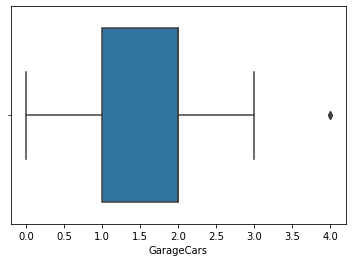

In [118]:
sns.boxplot(train_dataset['GarageCars'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


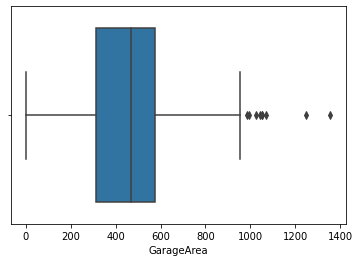

In [119]:
sns.boxplot(train_dataset['GarageArea'])

In [ ]:
iqr_GarageArea = iqr(train_dataset['GarageArea']) *1.5
Q75 = train_dataset['GarageArea'].quantile(0.75)
Q25 = train_dataset['GarageArea'].quantile(0.25)
print(iqr_GarageArea)
print(Q25,Q75)

396.0
308.0 572.0


In [120]:
train_dataset = train_dataset[train_dataset['GarageArea']<978]

In [171]:
# train_dataset['MSSubClass'] = train_dataset['MSSubClass'].astype(CategoricalDtype([20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190]))
train_dataset['OverallQual'] = train_dataset['OverallQual'].astype(CategoricalDtype([1,2,3,4,5,6,7,8,9,10]))
# train_dataset['OverallCond'] = train_dataset['OverallCond'].astype(CategoricalDtype([1,2,3,4,5,6,7,8,9,10]))

# Encoding catagorical data

In [ ]:
train_dataset = pd.concat([train_dataset,pd.get_dummies(train_dataset['MSSubClass'],prefix='MSSubClass',drop_first=True)],axis=1)

In [22]:
train_dataset.drop(['MSSubClass'],axis=1, inplace=True)

In [139]:
train_dataset = pd.concat([train_dataset,pd.get_dummies(train_dataset['OverallQual'],prefix='OverallQual',drop_first=True)],axis=1)

In [140]:
train_dataset.drop(['OverallQual'],axis=1, inplace=True)

In [ ]:
# train_dataset = pd.concat([train_dataset,pd.get_dummies(train_dataset['OverallCond'],prefix='OverallCond',drop_first=True)],axis=1)

In [ ]:
# train_dataset.drop(['OverallCond'],axis=1, inplace=True)

In [172]:
print(train_dataset)

        Id OverallQual  TotalBsmtSF  ...  GarageCars  GarageArea  1stFlrSF
0        1           7          856  ...           2         548       856
1        2           6         1262  ...           2         460      1262
2        3           7          920  ...           2         608       920
3        4           7          756  ...           3         642       961
4        5           8         1145  ...           3         836      1145
...    ...         ...          ...  ...         ...         ...       ...
1455  1456           6          953  ...           2         460       953
1456  1457           6         1542  ...           2         500      2073
1457  1458           7         1152  ...           1         252      1188
1458  1459           5         1078  ...           1         240      1078
1459  1460           5         1256  ...           1         276      1256

[1427 rows x 7 columns]


In [173]:
train_dataset = pd.concat([train_dataset,salePrice],axis=1)

# Training

In [174]:
train_dataset.dropna(inplace=True)

In [175]:
print(train_dataset)

          Id OverallQual  TotalBsmtSF  ...  GarageArea  1stFlrSF  SalePrice
0        1.0           7        856.0  ...       548.0     856.0     208500
1        2.0           6       1262.0  ...       460.0    1262.0     181500
2        3.0           7        920.0  ...       608.0     920.0     223500
3        4.0           7        756.0  ...       642.0     961.0     140000
4        5.0           8       1145.0  ...       836.0    1145.0     250000
...      ...         ...          ...  ...         ...       ...        ...
1455  1456.0           6        953.0  ...       460.0     953.0     175000
1456  1457.0           6       1542.0  ...       500.0    2073.0     210000
1457  1458.0           7       1152.0  ...       252.0    1188.0     266500
1458  1459.0           5       1078.0  ...       240.0    1078.0     142125
1459  1460.0           5       1256.0  ...       276.0    1256.0     147500

[1427 rows x 8 columns]


In [144]:
print(train_dataset.iloc[:,1:-1])

      TotalBsmtSF  GrLivArea  ...  OverallQual_9  OverallQual_10
0             856       1710  ...              0               0
1            1262       1262  ...              0               0
2             920       1786  ...              0               0
3             756       1717  ...              0               0
4            1145       2198  ...              0               0
...           ...        ...  ...            ...             ...
1455          953       1647  ...              0               0
1456         1542       2073  ...              0               0
1457         1152       2340  ...              0               0
1458         1078       1078  ...              0               0
1459         1256       1256  ...              0               0

[1460 rows x 13 columns]


In [53]:
train_dataset.columns

Index(['Id', 'LotArea', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'GarageArea',
       'OverallQual_2', 'OverallQual_3', 'OverallQual_4', 'OverallQual_5',
       'OverallQual_6', 'OverallQual_7', 'OverallQual_8', 'OverallQual_9',
       'OverallQual_10', 'SalePrice'],
      dtype='object')

In [176]:
reg = RandomForestRegressor(n_estimators=100)

In [177]:
reg.fit(train_dataset.iloc[:,1:-1],train_dataset['SalePrice'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [178]:
test_dataset = pd.read_csv('/content/drive/My Drive/Datasci/test.csv')

# Encoding catagorical data

In [179]:
test_dataset[col] = test_dataset[col].fillna(0)
test_dataset = test_dataset[col]

In [149]:
# test_dataset['MSSubClass'] = test_dataset['MSSubClass'].astype(CategoricalDtype([20,30,40,45,50,60,70,75,80,85,90,120,150,160,180,190]))
test_dataset['OverallQual'] = test_dataset['OverallQual'].astype(CategoricalDtype([1,2,3,4,5,6,7,8,9,10]))
# test_dataset['OverallCond'] = test_dataset['OverallCond'].astype(CategoricalDtype([1,2,3,4,5,6,7,8,9,10]))

In [130]:
print(test_dataset[col].isna().sum())

Id             0
OverallQual    0
TotalBsmtSF    0
GrLivArea      0
GarageCars     0
GarageArea     0
dtype: int64


In [150]:
# test_dataset = pd.concat([test_dataset,pd.get_dummies(test_dataset['MSSubClass'],prefix='MSSubClass',drop_first=True)],axis=1)
# test_dataset.drop(['MSSubClass'],axis=1, inplace=True)
test_dataset = pd.concat([test_dataset,pd.get_dummies(test_dataset['OverallQual'],prefix='OverallQual',drop_first=True)],axis=1)
test_dataset.drop(['OverallQual'],axis=1, inplace=True)
# test_dataset = pd.concat([test_dataset,pd.get_dummies(test_dataset['OverallCond'],prefix='OverallCond',drop_first=True)],axis=1)
# test_dataset.drop(['OverallCond'],axis=1, inplace=True)

In [180]:
print(test_dataset.iloc[:,1:])

      OverallQual  TotalBsmtSF  GrLivArea  GarageCars  GarageArea  1stFlrSF
0               5        882.0        896         1.0       730.0       896
1               6       1329.0       1329         1.0       312.0      1329
2               5        928.0       1629         2.0       482.0       928
3               6        926.0       1604         2.0       470.0       926
4               8       1280.0       1280         2.0       506.0      1280
...           ...          ...        ...         ...         ...       ...
1454            4        546.0       1092         0.0         0.0       546
1455            4        546.0       1092         1.0       286.0       546
1456            5       1224.0       1224         2.0       576.0      1224
1457            5        912.0        970         0.0         0.0       970
1458            7        996.0       2000         3.0       650.0       996

[1459 rows x 6 columns]


In [98]:
test_dataset.columns

Index(['Id', 'LotArea', 'OverallQual', 'TotalBsmtSF', 'GrLivArea',
       'GarageCars', 'GarageArea'],
      dtype='object')

In [181]:
result = reg.predict(test_dataset.iloc[:,1:])

In [182]:
print(result)

[125332.83       158719.2        148042.         ... 157253.09
 103732.08333333 233856.49      ]


In [183]:
ans=pd.DataFrame({'SalePrice':result})
submission = pd.concat([test_dataset['Id'],ans],axis=1)
submission.to_csv('/content/drive/My Drive/Datasci/outputrandom_forest18.csv', index=False)